# Environment Setup

In [1]:
# Import needed modules

import os
import sys
import gc
import time
import torch
import random
import numpy as np
from torch import optim
from torch.nn import Conv2d
from torch.utils.data import random_split, DataLoader
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML, Javascript

In [2]:
# Set seed for PyTorch reproducibility

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Mount google drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/vision_project/'

# Add path to the list of directories
sys.path.append(BASE_DIR + 'dataset')
sys.path.append(BASE_DIR + 'models/GSCNN')
sys.path.append(BASE_DIR + 'utils')

Mounted at /content/drive


# Data Preparation

The official resources for the WoodScape dataset are available at:

- GitHub: https://github.com/valeoai/WoodScape.git
- Google Drive: https://drive.google.com/drive/folders/1X5JOMEfVlaXfdNy24P8VA-jMs0yzf_HR

Reduced versions of the dataset can be accessed at:

- 3K Examples: https://drive.google.com/file/d/1DFi_amQfdZNOLAmxviQNMH2WN9C482lJ/view?usp=sharing
- 1K Examples: https://drive.google.com/file/d/1-GPPLdY8ZsuFmJQP9IfNr3dOCzc1_-OQ/view?usp=sharing

Note: As we do not have sufficient resources to process the entire dataset, we have created two reduced versions by randomly selecting 1K and 3K images. The code used for generating these versions is available at the following [link](https://drive.google.com/file/d/1aH1UCfUK1i53-UFgfSIOzqTcAAvBORaA/view?usp=sharing)

## Datset Loading

- **Input Image Transformations**:
All pre-trained models expect input images normalized in the same way.  Since we're using models pre-trained on the CityScapes dataset, we normalize image examples using the mean and standard deviation of that dataset.

- **Annotations Transformations**: The segmentation masks are converted into tensors of type 'long', and the class indices are adjusted to align with the 9 desired categories through a remapping process. This remapping specifically includes the integration of the 'lanemarks' class into the 'road' category. This approach is taken because, within the Cityscapes dataset, 'lanemarks' and 'road' are not separately categorized and are instead treated as a single class.



    ### Annotations ID MAP

    ID  class          newID  newClass

    0   void         ->  0    void
    1   road         ->  1    road
    2   lanemarks    ->  1    road
    3   curb         ->  2    curb
    4   person       ->  3    person
    5   rider        ->  4    rider
    6   pole         ->  5    pole
    7   vehicles     ->  6    vehicles
    8   traffic sign ->  7    traffic_sign
    9   motorcycle   ->  8    motorcycle
    

To optimize the use of limited resources in free Colab, we decided to divide the Woodscape dataset, which consists of approximately 8200 images with semantic annotations, into three groups, each containing 2700 images. This approach allows us to manage time and memory constraints by training the model on one group of images at a time. Consequently, to complete an entire training epoch, the notebook will need to be run three times, once for each group of images. This strategy enables us to make the most of the capabilities of free Colab while effectively advancing the training process of our model.

In [5]:
idxs = list(range(8100))
random.shuffle(idxs)

# dataset partitions
part1 = idxs[2700]
part2 = idxs[2700:5400]
part3 = idxs[5400:8100]

In [6]:
from woodscape import WoodScapesDataset
from woodscape_transforms import img_transform, annotation_transform, joint_transform, test_img_transform, test_annotation_transform, UnNormalize
from edge_utils import generate_edgemap

dataset_size = 8100
dataset_dir = BASE_DIR + 'dataset/woodscape/data/'

# split the dataset
generator = torch.Generator().manual_seed(42)
train_idxs, valid_idxs, test_idxs = random_split(range(50), [0.5, 0.25, 0.25], generator=generator)

train_data = WoodScapesDataset(img_dir = dataset_dir + 'images',
                               annotation_dir= dataset_dir + 'semantic_annotations',
                               idxs = train_idxs,
                               transform=img_transform,
                               target_transform=annotation_transform,
                               joint_transform=joint_transform,
                               include_edgemap=True
                               )
valid_data = WoodScapesDataset(img_dir = dataset_dir + 'images',
                               annotation_dir= dataset_dir + 'semantic_annotations',
                               idxs = valid_idxs,
                               transform=img_transform,
                               target_transform=annotation_transform,
                               joint_transform=joint_transform,
                               include_edgemap=True
                               )
test_data = WoodScapesDataset(img_dir = dataset_dir + 'images',
                              annotation_dir= dataset_dir + 'semantic_annotations',
                              idxs = test_idxs,
                              transform=test_img_transform,
                              target_transform=test_annotation_transform,
                              )

## Dataset Exploration

After successfully loading the dataset, we move on to the exploratory analysis to examine its key features, including the number of classes, the labels for each class with their corresponding colors, and the dimensions of the images. Additionally, we display some image examples from the dataset to gain a clearer understanding of its composition and the type of information it holds.

In [7]:
# Basic information about the dataset

num_classes = 9
classes = ("void", "road", "curb", "person", "rider", "vehicles", "bicycle", "motorcycle", "traffic_sign")
colors = [[0, 0, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [255, 255, 0], [0, 255, 255], [128, 128, 255], [0, 128, 128]]
colormap = torch.tensor(colors) # tensor colormap

print("### WoodScape Dataset ###")
print("-"*30)
print(f"N. of Classes: {num_classes}")
print(f"N. of Examples: {dataset_size}\n")
print(f"Image size: {list(test_data[0][0].size())}")  # image size
print(f"Mask size:  {list(test_data[0][1].size())}")  # semantic annotation size

### WoodScape Dataset ###
------------------------------
N. of Classes: 9
N. of Examples: 8100

Image size: [3, 960, 1280]
Mask size:  [960, 1280]


### Test Example ###
Image size: torch.Size([3, 960, 1280])
Semantic Annotation size: torch.Size([960, 1280])
Edge Map size: torch.Size([1, 960, 1280])



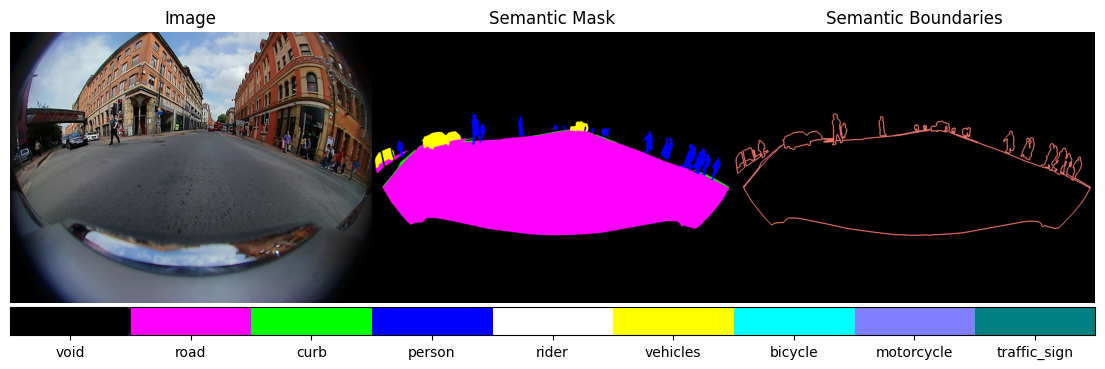

In [ ]:
image, mask = test_data[0]
edgemap = generate_edgemap(mask)

edge_cmap = torch.tensor([[0,0,0], [237, 115, 107]])

fig = plt.figure(figsize=(14, 4))
spec = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[1, 1, 1], height_ratios=[10, 1], wspace=0, hspace=0)

ax0 = fig.add_subplot(spec[0])
ax0.imshow(UnNormalize(image).permute(1,2,0))
ax0.set_title("Image")
ax0.axis('off')

ax1 = fig.add_subplot(spec[1])
ax1.imshow(colormap[mask])
ax1.set_title("Semantic Mask")
ax1.axis('off')

ax2 = fig.add_subplot(spec[2])
ax2.imshow(edge_cmap[edgemap.squeeze().long()])
ax2.set_title("Semantic Boundaries")
ax2.axis('off')

ax3 = fig.add_subplot(spec[3:])
ax3.imshow(colormap[torch.tensor(range(9)).view(1, -1)], aspect='auto')
ax3.set_xticks(range(len(classes)))
ax3.set_xticklabels(classes, rotation=0)
ax3.yaxis.set_visible(False)

print("### Test Example ###")
print(f"Image size: {image.size()}")
print(f"Semantic Annotation size: {mask.size()}")
print(f"Edge Map size: {edgemap.size()}\n")

plt.show()

### Training Example ###
Image size: torch.Size([3, 483, 483])
Semantic Annotation size: torch.Size([483, 483])
Edge Map size: torch.Size([1, 483, 483])



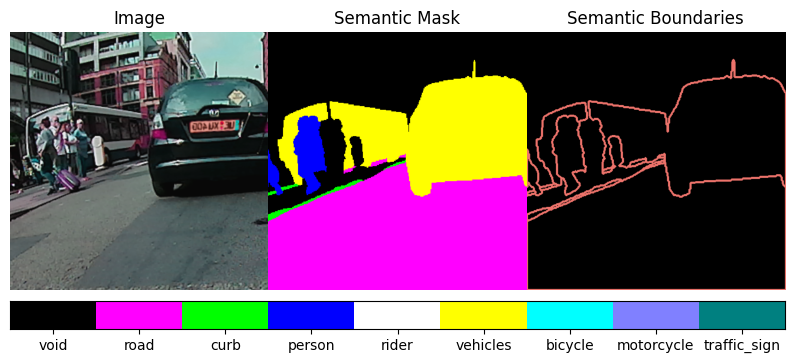

In [ ]:
image, mask, edgemap = train_data[0]
#edgemap = generate_edgemap(mask)

fig = plt.figure(figsize=(10, 4))
spec = gridspec.GridSpec(ncols=3, nrows=2,
                         width_ratios=[1, 1, 1], height_ratios=[10, 1], wspace=0, hspace=0)

ax0 = fig.add_subplot(spec[0])
ax0.imshow(UnNormalize(image).permute(1,2,0))
ax0.set_title("Image")
ax0.axis('off')

ax1 = fig.add_subplot(spec[1])
ax1.imshow(colormap[mask])
ax1.set_title("Semantic Mask")
ax1.axis('off')

ax2 = fig.add_subplot(spec[2])
ax2.imshow(edge_cmap[edgemap.squeeze().long()])
ax2.set_title("Semantic Boundaries")
ax2.axis('off')

ax3 = fig.add_subplot(spec[3:])
ax3.imshow(colormap[torch.tensor(range(9)).view(1, -1)], aspect='auto')
ax3.set_xticks(range(len(classes)))
ax3.set_xticklabels(classes, rotation=0)
ax3.yaxis.set_visible(False)

print("### Training Example ###")
print(f"Image size: {image.size()}")
print(f"Semantic Annotation size: {mask.size()}")
print(f"Edge Map size: {edgemap.size()}\n")

plt.show()

## Batch Iterators

In [ ]:
# create batch iterators
train_iterator = DataLoader(train_data, batch_size=5, drop_last=True)
valid_iterator = DataLoader(valid_data, batch_size=5, drop_last=True)
test_iterator = DataLoader(test_data, batch_size=3, drop_last=True)

print(f"Number of Training Batches: {len(train_iterator)}")
print(f"Number of Validation Batches: {len(valid_iterator)}")
print(f"Number of Test Batches: {len(test_iterator)}")

Number of Training Batches: 5
Number of Validation Batches: 2
Number of Test Batches: 4


# Network

### Download and Load the Model
- GitHub: https://github.com/nv-tlabs/GSCNN.git
- Model Checkpoints \(Google Drive\): https://drive.google.com/file/d/1wlhAXg-PfoUM-rFy2cksk43Ng3PpsK2c/view

In [ ]:
from network.gscnn import GSCNN

ckp_dir = BASE_DIR + "models/checkpoints/"

# Load GSCNN (pre-trained on CityScapes)
gscnn = GSCNN(num_classes=19)
weights = torch.load(ckp_dir + "best_gcnn_state_dict.pt", map_location=torch.device('cpu'))
gscnn.load_state_dict(weights, strict=False)

/content/drive/MyDrive/vision_project/models/GSCNN/network/mynn.py:29: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


<All keys matched successfully>

In [ ]:
# Model size

total_params = sum(p.numel() for p in gscnn.parameters())
trainable_params = sum(p.numel() for p in gscnn.parameters() if p.requires_grad)
total_bytes = sum(p.numel() * p.element_size() for p in gscnn.parameters())
total_gb = total_bytes / (1024 ** 3)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Total memory occupied by model parameters on GPU: {total_gb:.2f} GB")

Total parameters: 137278190
Trainable parameters: 137278190
Total memory occupied by model parameters on GPU: 0.51 GB


# Evaluation metric

The function mIoU is designed to compute the mean Intersection over Union (mIoU) metric, which is a common evaluation metric for semantic segmentation tasks in machine learning and computer vision. This metric evaluates the accuracy of a predicted segmentation by comparing it with the ground truth segmentation on a class-by-class basis.

In [ ]:
def calculate_IoU(conf_matrix):
    # Extract true positives, false positives, and false negatives
    intersection = np.diag(conf_matrix)
    ground_truth_set = conf_matrix.sum(axis=1)
    predicted_set = conf_matrix.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    # Avoid division by zero
    IoU = intersection / np.maximum(union, 1)

    return IoU

def calculate_f1_score(conf_matrix):
    # Initialize variables to accumulate precision and recall for each class
    num_classes = conf_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_scores = np.zeros(num_classes)

    for i in range(num_classes):
        true_positive = conf_matrix[i, i]
        false_positive = conf_matrix[:, i].sum() - true_positive
        false_negative = conf_matrix[i, :].sum() - true_positive

        if true_positive + false_positive == 0:
            precision[i] = 0
        else:
            precision[i] = true_positive / (true_positive + false_positive)

        if true_positive + false_negative == 0:
            recall[i] = 0
        else:
            recall[i] = true_positive / (true_positive + false_negative)

        if precision[i] + recall[i] == 0:
            f1_scores[i] = 0
        else:
            f1_scores[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    # Calculate the macro F1-score
    macro_f1_score = np.mean(f1_scores)
    return macro_f1_score

# Experiment 1

###Pre-trained Model Evaluation

The Gated-SCNN model is pretrained on the Cityscapes Dataset, which includes annotations for 19 different semantic classes. Since our target dataset, WoodScape, contains only 9 classes, we created a mapping to associate each of the Cityscapes classes with a corresponding class in WoodScape. This mapping allowed us to test the pre-trained models on the new dataset.


    ID  cityscapesClass       newID    woodscapeClass

    0   road                 -> 1      road
    1   sidewalk             -> 2      curb
    2   building             -> 0      void
    3   wall                 -> 0      void
    4   fence                -> 0      void
    5   pole                 -> 0      void
    6   traffic light        -> 0      void
    7   traffic sign         -> 8      traffic_sign
    8   vegetation           -> 0      void
    9   terrain              -> 0      void
    10  sky                  -> 0      void
    11  person               -> 3      person
    12  rider                -> 4      rider
    13  car                  -> 5      vehicles
    14  truck                -> 5      vehicles
    15  bus                  -> 5      vehicles
    16  train                -> 5      vehicles
    17  motorcycle           -> 7      motorcycle
    18  bicycle              -> 6      bicycle

In [ ]:
# map CityScapes ID to WoodScape ID
id_map = torch.tensor([1,2,0,0,0,0,0,8,0,0,0,3,4,5,5,5,5,7,6])

### Pre-trained model performance

In [ ]:
# Predictions from GSCNN (pre-trained on CityScapes)

gscnn.cuda()
gscnn.eval()

with torch.no_grad():
    x, y = next(iter(test_iterator))
    x, y = x.cuda(), y.cuda()

    seg_out, edge_out = gscnn(x)
    seg_out = seg_out.detach().cpu()
    y_pred = seg_out.detach().max(1)[1].cpu()

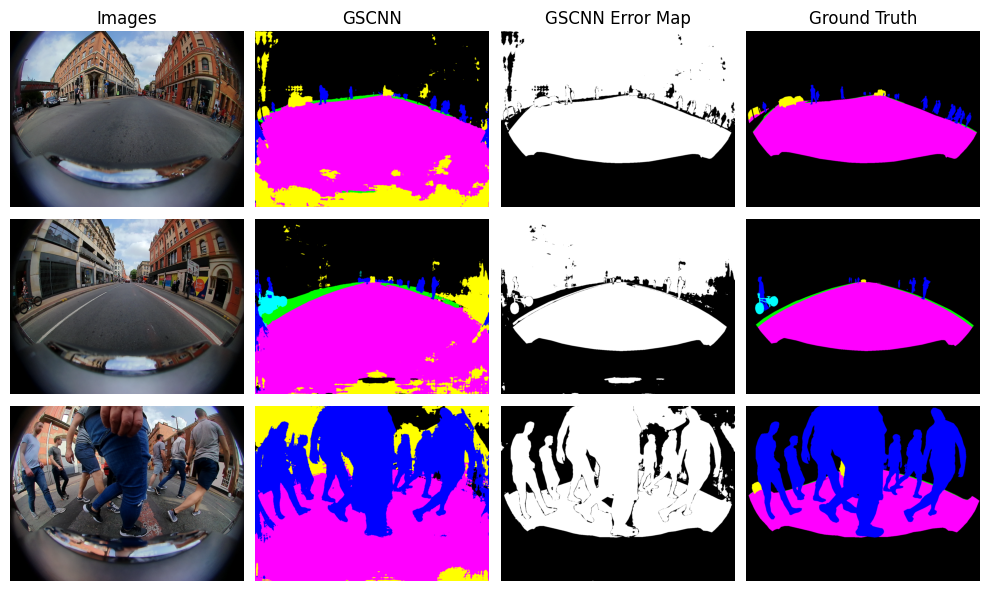

In [ ]:
# Qualitative evaluation of the model pre-trained on CityScape

x = x.cpu()
y = y.long().cpu()
pred = y_pred.long().cpu()
pred = id_map[pred]

fig, axs = plt.subplots(len(x), 4, figsize=(10, 6))
for i, (img, gt, pred) in enumerate(zip(x, y, pred)):
    axs[i, 0].imshow(colormap[gt])
    axs[i, 1].imshow(UnNormalize(img).permute(1, 2, 0))
    axs[i, 2].imshow(colormap[pred])
    axs[i, 3].imshow(gt==pred, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    axs[i, 3].axis('off')
    axs[0, 0].title.set_text('Ground Truth')
    axs[0, 1].title.set_text('Images')
    axs[0, 2].title.set_text('GSCNN')
    axs[0, 3].title.set_text('GSCNN Error Map')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

# Experiment 2

##Fine Tuning

In the second experiment, we aimed to retrain the two models to better adapt to the new dataset. Our objective was to assess whether the models could learn the radial distortion characteristic of the Woodscape dataset, as the models pre-trained on CityScape did not perform adequately, as evidenced by the results of the first experiment.

In [ ]:
load_pretrained = True

ckp_dir = BASE_DIR + "models/checkpoints/"

if load_pretrained:
    # Load GSCNN (pre-trained on CityScapes)
    gscnn = GSCNN(num_classes=19)
    state_dict = torch.load(ckp_dir+"best_gcnn_state_dict.pt", map_location=torch.device('cpu'))
    gscnn.load_state_dict(state_dict)

    # Adjust last layer to match the right number of classes
    print("Before: ", gscnn.final_seg[6])
    gscnn.final_seg[6] = Conv2d(256, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)
    print("After:  ", gscnn.final_seg[6])

else:
    # Load GSCNN (fine-tuned on WoodScape)
    gscnn = GSCNN(num_classes=9)
    weights = torch.load(ckp_dir + "gscnn_m6_e5p3.pt", map_location=torch.device('cpu'))
    gscnn.load_state_dict(weights, strict=False);

Before:  Conv2d(256, 19, kernel_size=(1, 1), stride=(1, 1), bias=False)
After:   Conv2d(256, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
trainable_params_before = sum(p.numel() for p in gscnn.parameters() if p.requires_grad)

layers_to_freeze = ['mod1', 'pool2', 'mod2', 'pool3', 'mod3', 'mod4']

for name, child in gscnn.named_children():
    if name in layers_to_freeze:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True

trainable_params_after = sum(p.numel() for p in gscnn.parameters() if p.requires_grad)

print(f"Trainable parameters (before freezing): {trainable_params_before}")
print(f"Trainable parameters (after freezing) : {trainable_params_after}")


Trainable parameters (before freezing): 137275630
Trainable parameters (after freezing) : 105898926


In [ ]:
from loss3 import JointEdgeSegLoss

# Criterion
criterion = JointEdgeSegLoss(classes=9, mode='train').cuda()
criterion_val = JointEdgeSegLoss(classes=9, mode='val').cuda()
gscnn.criterion = criterion

# Optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, gscnn.parameters()),
                      lr=0.0005,
                      weight_decay=1e-4,
                      momentum=0.9,
                      nesterov=False)

# Scheduler
total_epochs = 5
start_epoch = 0 # aggiorna solo questo valore
power = 0.9
lambda_poly = lambda epoch: (1 - (epoch + start_epoch) / total_epochs) ** power
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_poly)


In [ ]:
lr = 0.0005
for ep in range(total_epochs):
  print(f"Epoch {ep+1:02}, lr : {(lambda_poly(ep)*lr)}")

Epoch 01, lr : 0.0005
Epoch 02, lr : 0.00040902607302542923
Epoch 03, lr : 0.00031572293374467766
Epoch 04, lr : 0.00021919164527704348
Epoch 05, lr : 0.00011746189430880188


## Optimization Loop

In [ ]:
def train(train_loader, model, criterion, optimizer):

    model.train()

    epoch_loss = 0
    seg_loss = 0
    edge_loss = 0
    att_loss = 0
    dual_loss = 0
    i = 1

    for (img, mask, edgemap) in train_loader:

        # update progress bar
        elapsed_time = int(time.time() - start_time)
        progress = int((i / len(train_loader)) * 100)
        move_progress(progress, elapsed_time, i, len(train_loader), "Training")

        img, mask, edgemap = img.cuda(), mask.cuda(), edgemap.cuda()

        optimizer.zero_grad()
        loss_dict = model(inp=img, gts=(mask, edgemap))

        loss = loss_dict['seg_loss'] + loss_dict['edge_loss'] + loss_dict['att_loss'] + loss_dict['dual_loss']

        loss.backward()
        optimizer.step()

        if i%48 == 0:
            print(f"Batch: {i:03}/{len(train_loader)} -- Loss: {loss.item():.2f}")

        epoch_loss += loss.item()
        seg_loss += loss_dict['seg_loss'].item()
        edge_loss += loss_dict['edge_loss'].item()
        att_loss += loss_dict['att_loss'].item()
        dual_loss += loss_dict['dual_loss'].item()
        i += 1

    epoch_loss = epoch_loss / len(train_loader)
    seg_loss = seg_loss / len(train_loader)
    edge_loss = edge_loss / len(train_loader)
    att_loss = att_loss / len(train_loader)
    dual_loss = dual_loss / len(train_loader)

    return epoch_loss, seg_loss, edge_loss, att_loss, dual_loss

def validate(valid_loader, model, criterion, optimizer):

    model.eval()

    epoch_loss = 0
    cm = np.zeros((9,9), dtype=np.int64)
    i = 1

    for (img, mask, edgemap) in valid_loader:

        # update progress bar
        elapsed_time = int(time.time() - start_time)
        progress = int((i / len(valid_loader)) * 100)
        move_progress(progress, elapsed_time, i, len(valid_loader), "Validation")

        img, mask, edgemap = img.cuda(), mask.cuda(), edgemap.cuda()

        with torch.no_grad():

            seg_out, edge_out = model(inp=img, gts=(mask, edgemap))

            loss_dict = criterion_val((seg_out, edge_out), (mask, edgemap))
            epoch_loss += sum(loss_dict.values()).item()

            seg_out = seg_out.detach().cpu()
            y_pred = seg_out.max(1)[1]

            y_true = mask.cpu().view((-1,)).numpy()
            y_pred = y_pred.view((-1,)).numpy()
            cm += confusion_matrix(y_true, y_pred, labels=range(9))

        i += 1

    epoch_loss = epoch_loss / len(valid_loader)
    iou = calculate_IoU(cm)
    miou = np.mean(iou)

    return epoch_loss, miou

def model_training(n_epochs, train_loader, valid_loader, model, criterion, optimizer, scheduler=None, model_name='best_gcnn.pt'):

    torch.cuda.empty_cache()

    best_valid_loss = float('inf')

    train_losses = []
    valid_losses = []
    valid_accs = []

    # Display progress bar and time
    display(HTML(html_str))
    display(Javascript(js_str))

    for epoch in range(n_epochs):

        train_loss = train(train_loader, model, criterion, optimizer)
        valid_loss, valid_acc = validate(valid_loader, model, criterion, optimizer)

        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), model_name)

        # Learning Rate Update
        current_lr = optimizer.param_groups[0]['lr']
        if scheduler:
            scheduler.step()

        end_time = time.time()
        t = end_time - start_time
        min = t//60
        sec = int(((t/60)-(t//60))*100)

        print(f"\nEpoch: {epoch + 1}/{n_epochs} -- Epoch Time: {min}m {sec}s")
        print(f"Current learning rate: {current_lr:.6f}")
        print("---------------------------------")
        print(f"Train -- Loss: {train_loss[0]:.3f}, SegLoss: {train_loss[1]:.3f}, EdgeLoss: {train_loss[2]:.3f}, AttLoss: {train_loss[3]:.3f}, DualLoss: {train_loss[4]:.3f}")
        print(f"Validation -- Loss: {valid_loss:.3f}, mIoU: {valid_acc * 100:.2f}%")

        train_losses.append(train_loss[0])
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

    return train_losses, valid_losses, valid_accs

## Training and Evaluation

In [ ]:
from debug_utils import html_str, js_str, move_progress

gscnn.cuda()
start_time = time.time()

train_losses, valid_losses, valid_accs = model_training(n_epochs = 1,
                                                        train_loader = train_iterator,
                                                        valid_loader = valid_iterator,
                                                        model = gscnn,
                                                        criterion = criterion,
                                                        optimizer = optimizer,
                                                        scheduler = None,
                                                        model_name = ckp_dir+'new_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Epoch: 1/1 -- Epoch Time: 0.0m 86s
Current learning rate: 0.000500
---------------------------------
Train -- Loss: 5.166, SegLoss: 1.416, EdgeLoss: 0.681, AttLoss: 3.034, DualLoss: 0.035
Validation -- Loss: 1.688, mIoU: 19.40%


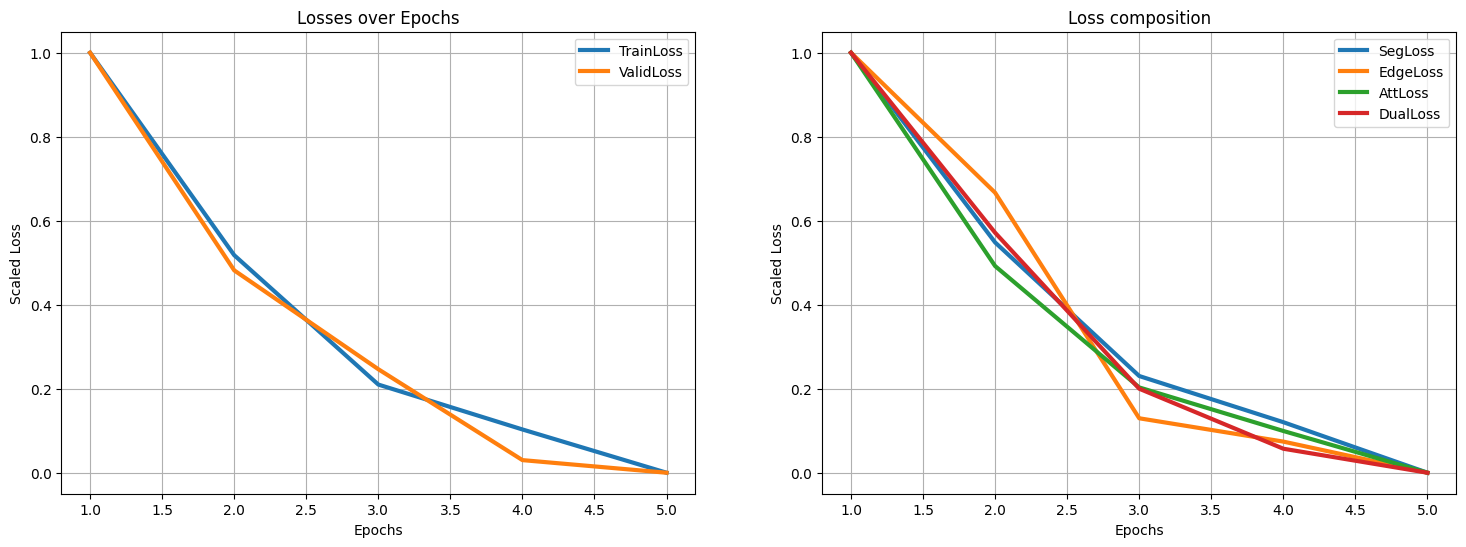

In [ ]:
from sklearn.preprocessing import MinMaxScaler

TrainLoss = np.mean([[4.741, 4.741, 4.110], [4.361, 4.219, 3.533], [3.973, 3.914, 3.281], [3.844, 3.844, 3.152], [3.766, 3.696, 3.062]], axis=1)
SegLoss = np.mean([[1.331,1.331, 1.155], [1.183, 1.116, 0.906], [0.998, 0.983, 0.793], [0.942, 0.942, 0.741], [0.907, 0.873, 0.682]], axis=1)
EdgeLoss = np.mean([[1.082, 1.082, 0.920], [1.076, 1.083, 0.907], [1.079, 1.054, 0.904], [1.070, 1.070, 0.894], [1.066, 1.070, 0.894]], axis=1)
AttLoss = np.mean([[2.295, 2.295, 2.006], [2.073, 1.992, 1.698], [1.872, 1.853, 1.564], [1.810, 1.810, 1.499], [1.771, 1.732, 1.453]], axis=1)
DualLoss = np.mean([[0.033, 0.033, 0.029], [0.029, 0.028, 0.023], [0.024, 0.024, 0.019], [0.022, 0.022, 0.018], [0.022, 0.021, 0.017]], axis=1)
ValidLoss = np.mean([[1.754, 1.754, 1.548], [1.603, 1.648, 1.477], [1.623, 1.590, 1.366], [1.551, 1.551, 1.340], [1.587, 1.538, 1.298]], axis=1)

# Combine into a single array for scaling
data = np.vstack([TrainLoss, SegLoss, EdgeLoss, AttLoss, DualLoss, ValidLoss]).T

# Apply MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Plot the scaled data
fig = plt.figure(figsize=(18, 6))

epochs = np.arange(1, len(TrainLoss) + 1)

plt.subplot(1,2,1)
plt.plot(epochs, data_scaled[:, 0], label='TrainLoss', linewidth=3)
plt.plot(epochs, data_scaled[:, 5], label='ValidLoss',  linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Scaled Loss')
plt.title('Losses over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, data_scaled[:, 1], label='SegLoss',  linewidth=3)
plt.plot(epochs, data_scaled[:, 2], label='EdgeLoss',  linewidth=3)
plt.plot(epochs, data_scaled[:, 3], label='AttLoss',  linewidth=3)
plt.plot(epochs, data_scaled[:, 4], label='DualLoss',  linewidth=3)
plt.xlabel('Epochs')
plt.ylabel('Scaled Loss')
plt.title('Loss composition')
plt.legend()
plt.grid(True)

plt.show()
fig.savefig('gscnn-loss.png', format='png', dpi=300, bbox_inches='tight')

In [ ]:
# Clear GPU
del criterion, criterion_val
torch.cuda.empty_cache()
gc.collect()

56659


## Qualitative results

In [ ]:
# Load GSCNN (fine-tuned on WoodScape)
gscnn = GSCNN(num_classes=9)
weights = torch.load(ckp_dir + "gscnn_m6_e5p3.pt", map_location=torch.device('cpu'))
gscnn.load_state_dict(weights, strict=False);

/content/drive/MyDrive/vision_project/models/GSCNN/network/mynn.py:29: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(module.weight)


In [ ]:
# Predictions from GSCNN (fine-tuned on WoodScape)

gscnn.cuda()
gscnn.eval()

with torch.no_grad():
    x, y = next(iter(test_iterator))
    x, y = x.cuda(), y.cuda()

    seg_out, edge_out = gscnn(x)
    seg_out = seg_out.detach().cpu()
    y_pred = seg_out.detach().max(1)[1].cpu()

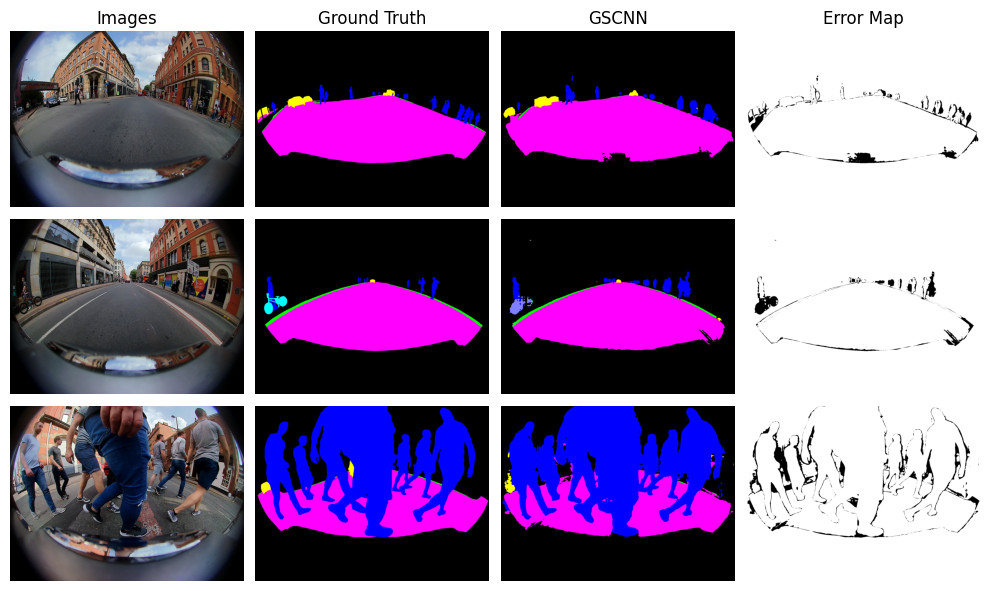

In [ ]:
x = x.cpu()
y = y.long().cpu()
pred = y_pred.long().cpu()

fig, axs = plt.subplots(len(x), 4, figsize=(10, 6))
for i, (img, gt, pred) in enumerate(zip(x, y, pred)):
    axs[i, 0].imshow(UnNormalize(img).permute(1, 2, 0))
    axs[i, 1].imshow(colormap[gt])
    axs[i, 2].imshow(colormap[pred])
    axs[i, 3].imshow(gt==pred, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
    axs[i, 3].axis('off')
    axs[0, 0].title.set_text('Images')
    axs[0, 1].title.set_text('Ground Truth')
    axs[0, 2].title.set_text('GSCNN')
    axs[0, 3].title.set_text('Error Map')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

## Testing phase

In [ ]:
# Predictions from GSCNN (fine-tuned on WoodScape)

gscnn.cuda()
gscnn.eval()

cm_2 = np.zeros((9,9), dtype=np.int64)

start_time = time.time()
display(HTML(html_str))
display(Javascript(js_str))

with torch.no_grad():
  for (x, y) in test_iterator:
    x = x.cuda()
    y = y.cuda()

    elapsed_time = int(time.time() - start_time)
    progress = int((i / len(test_iterator)) * 100)
    move_progress(progress, elapsed_time, i, len(test_iterator), "Test")

    seg_out, edge_out = gscnn(x)
    seg_out = seg_out.detach().cpu()
    y_pred = seg_out.max(1)[1]

    y_true = y.cpu().view((-1,)).numpy()
    y_pred = y_pred.view((-1,)).numpy()

    cm_2 += confusion_matrix(y_true, y_pred, labels=range(9))

iou_2 = calculate_IoU(cm_2)
miou_2 = np.mean(iou_2)
f1_score_2 = calculate_f1_score(cm_2)

print(f"Test -- mIoU: {miou_2*100:.2f}%")
print(f"Test -- f1-score: {f1_score_2:.2f}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test -- mIoU: 43.55%
Test -- f1-score: 0.48
